### Multi-input Network - Pytorch

Prediction action sequence that connects two observations

### Imports

In [2]:
import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [3]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

### Preprocess data

In [4]:
n = 4

# change seq. length, recode actions, split dataset
dataset = preprocess.split_n_steps_between(oracle_random_data, n=n)
dataet, counter, classes_expl = preprocess.recode_actions(dataset, n)
train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset
oracle_train_data = preprocess.ObtainDualDataset(
    train_data, "observationsA", "observationsB", "actions"
)
oracle_test_data = preprocess.ObtainDualDataset(
    test_data, "observationsA", "observationsB", "actions"
)

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(
    oracle_train_data, batch_size=batch_size, shuffle=True
)
dataset_loader_test_data = DataLoader(
    oracle_test_data, batch_size=batch_size, shuffle=True
)

### Two images within one batch (n-steps inbetween)

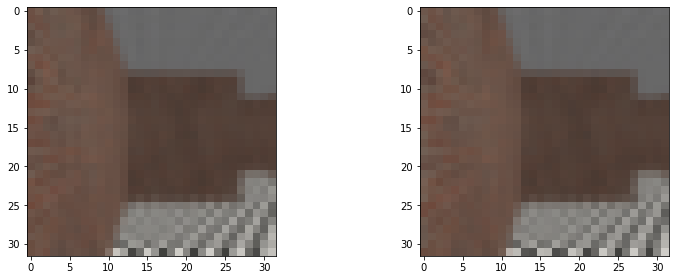

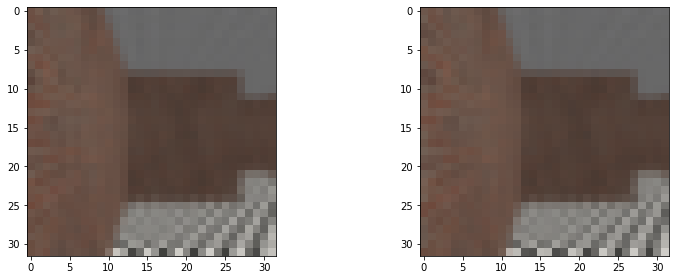

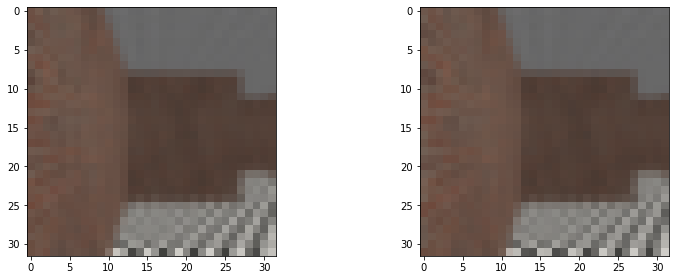

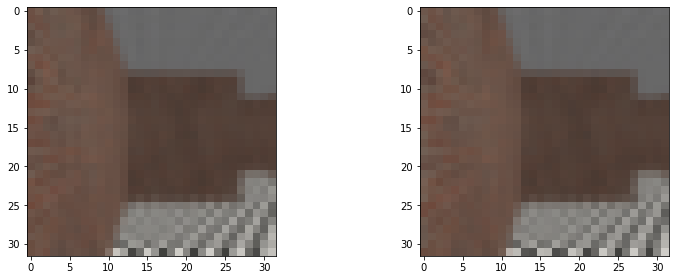

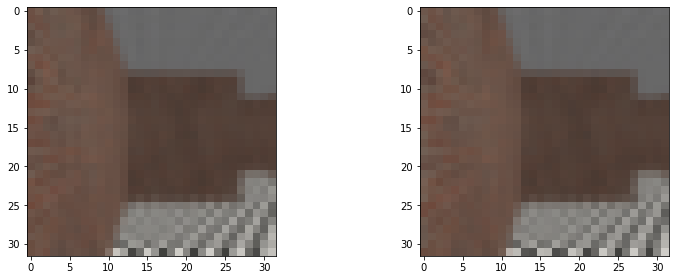

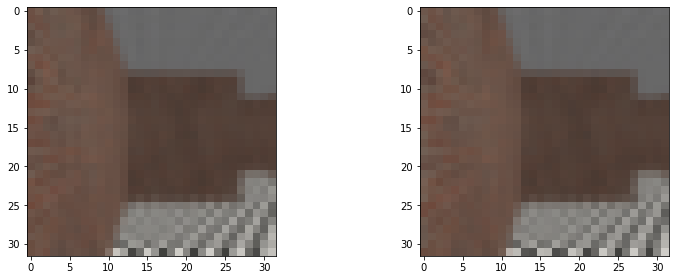

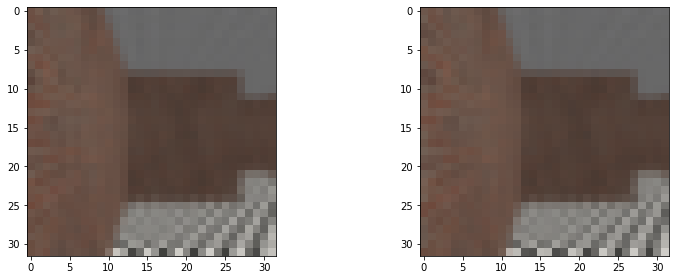

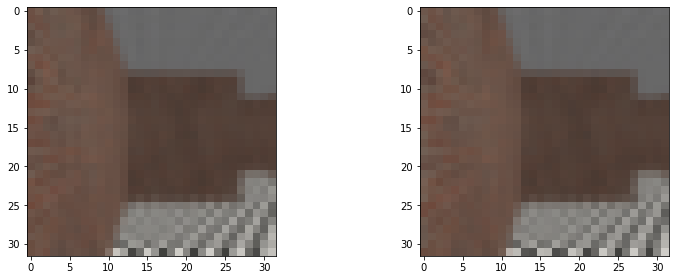

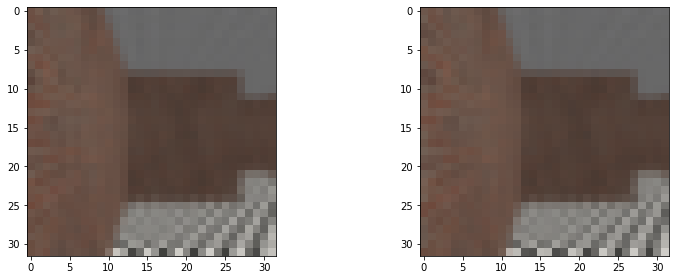

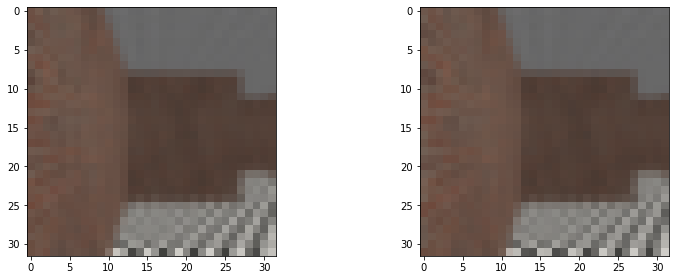

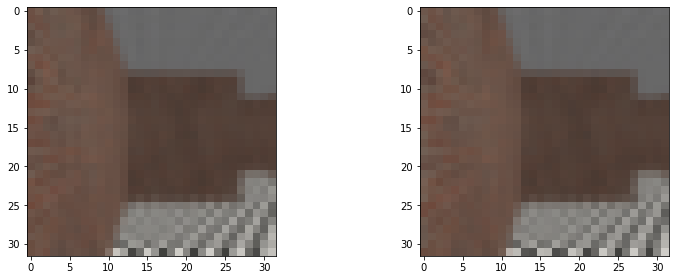

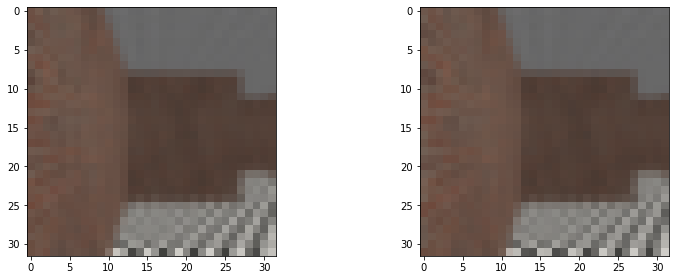

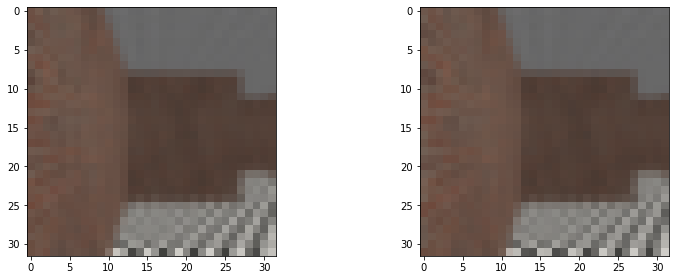

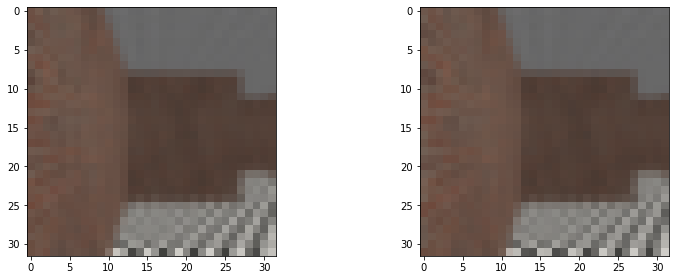

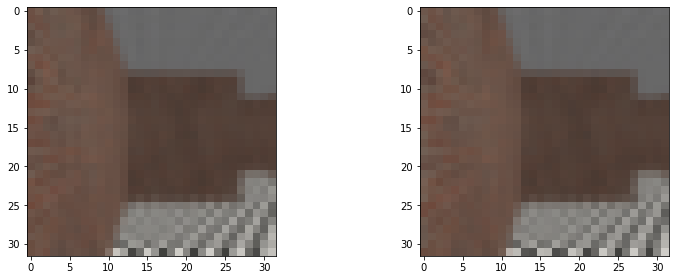

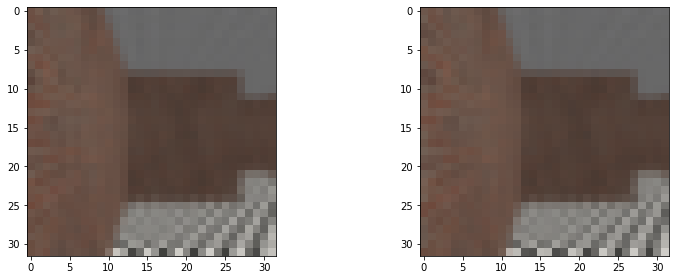

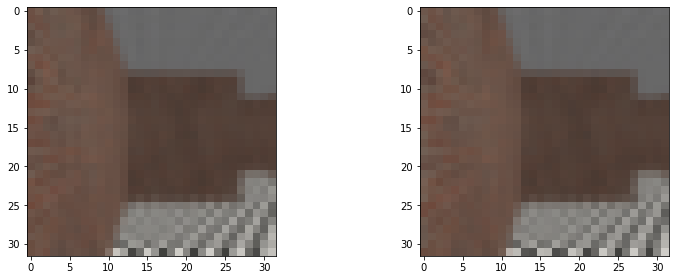

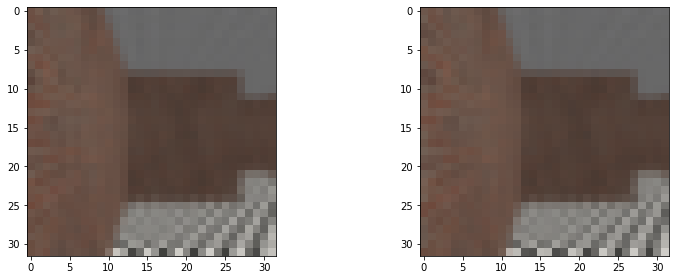

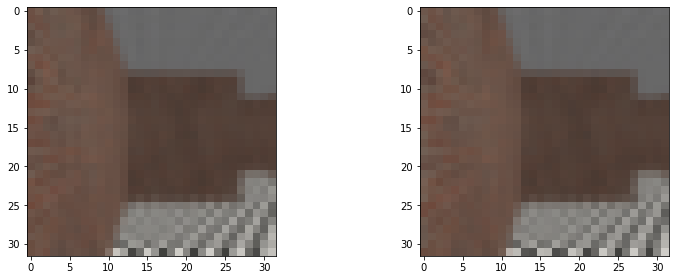

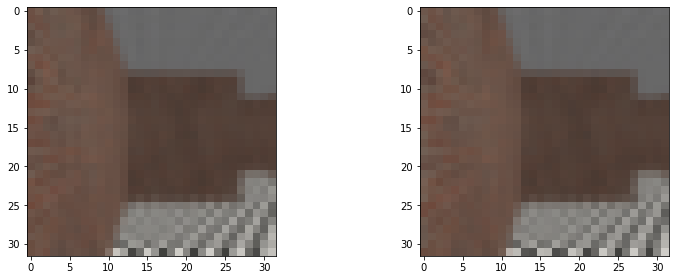

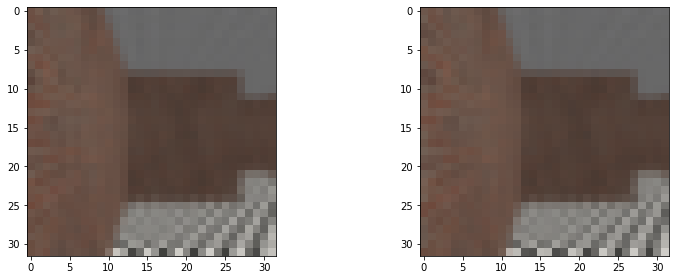

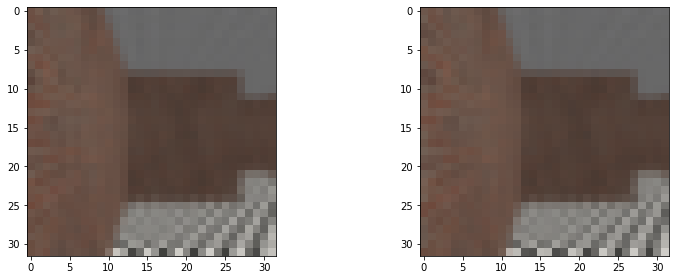

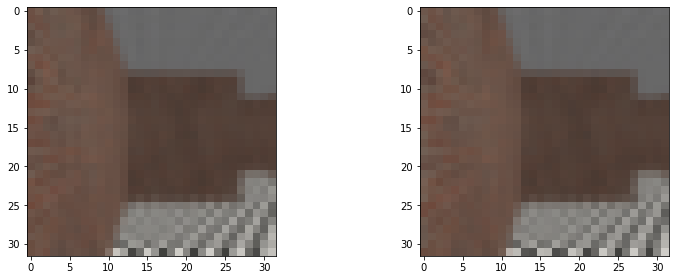

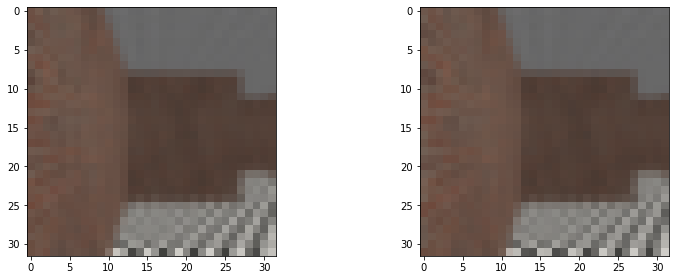

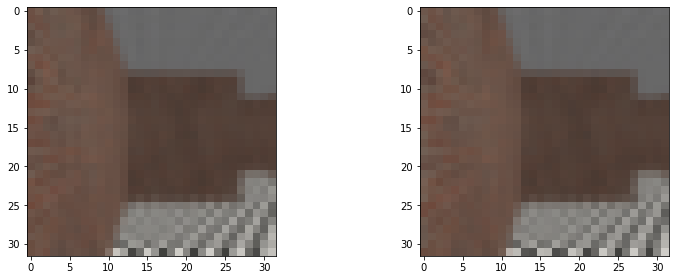

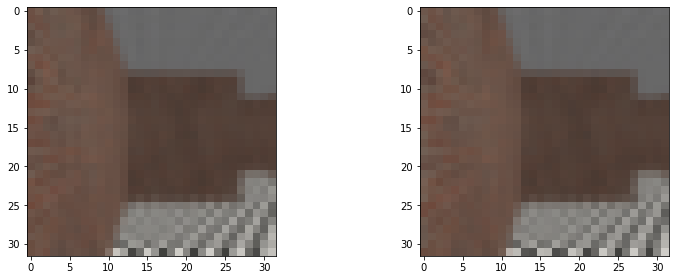

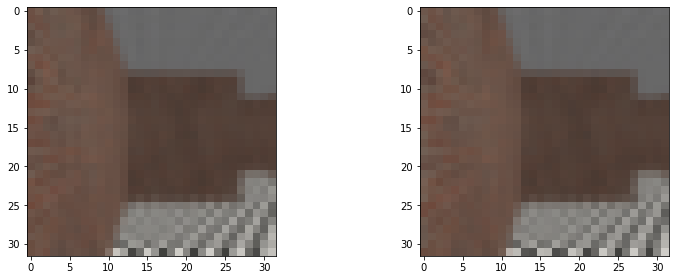

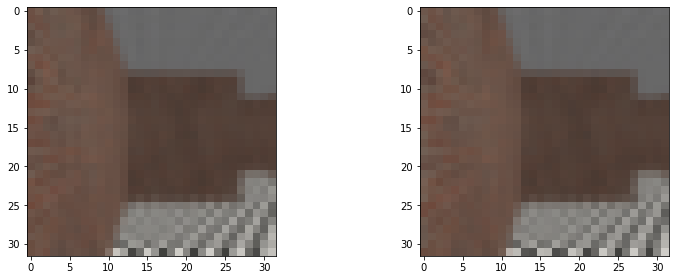

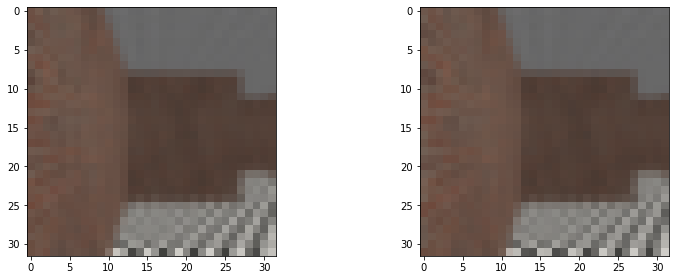

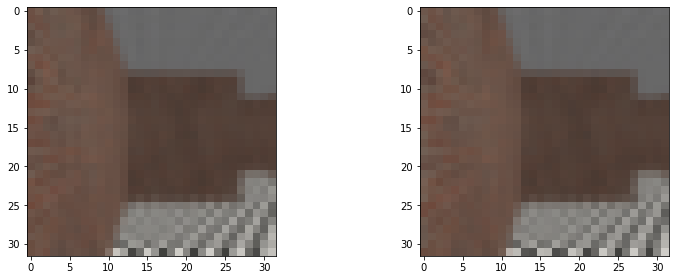

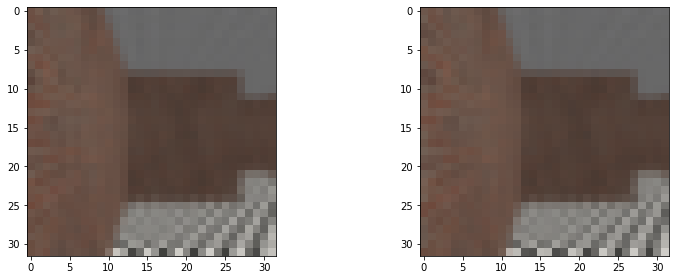

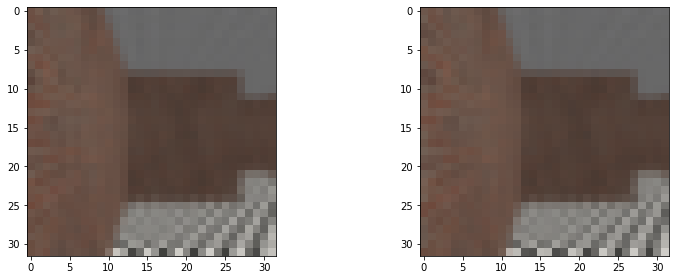

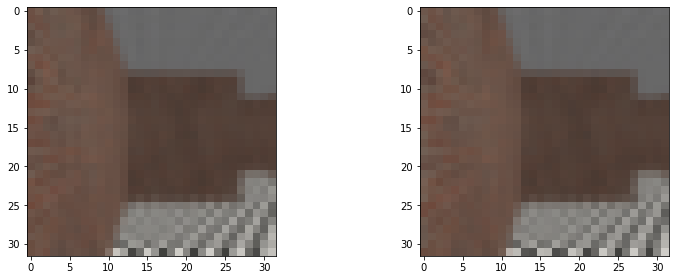

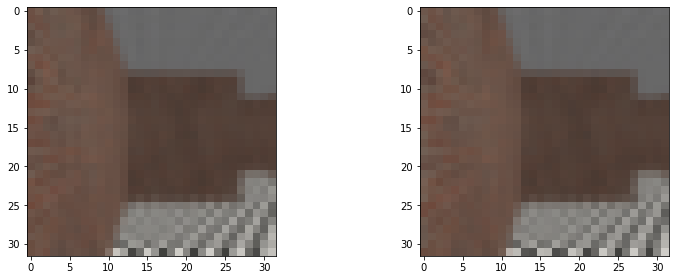

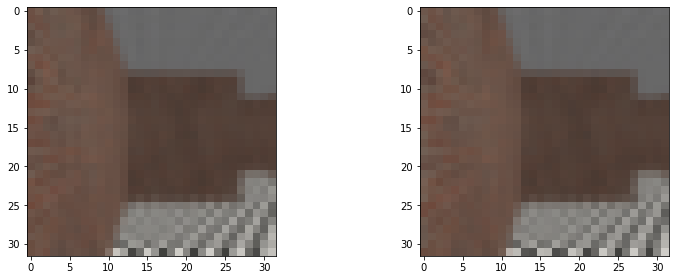

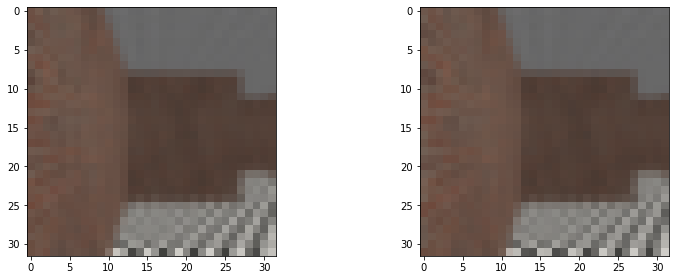

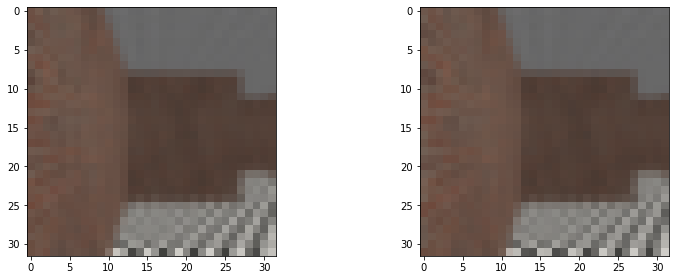

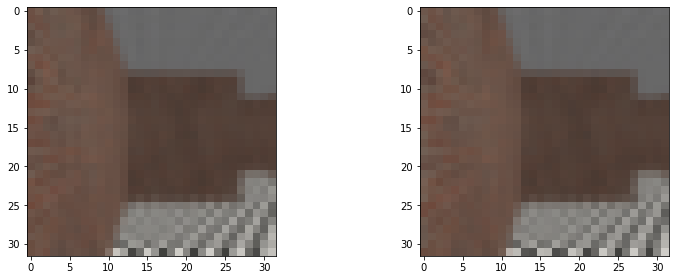

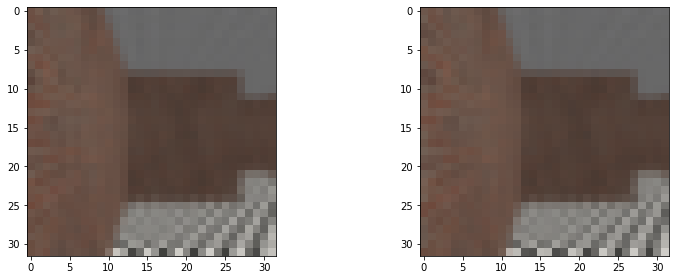

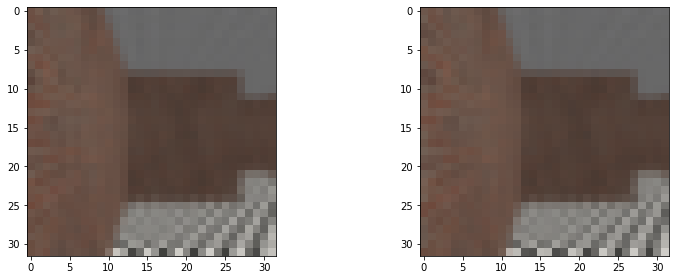

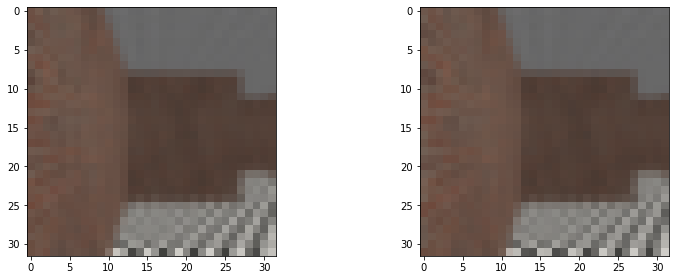

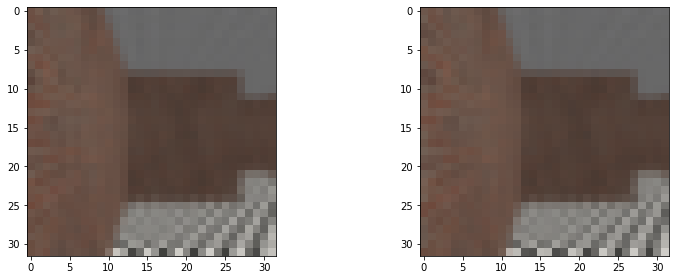

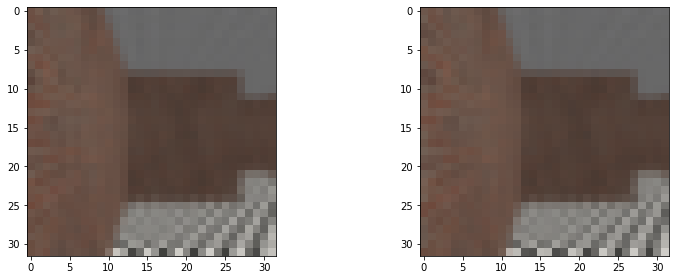

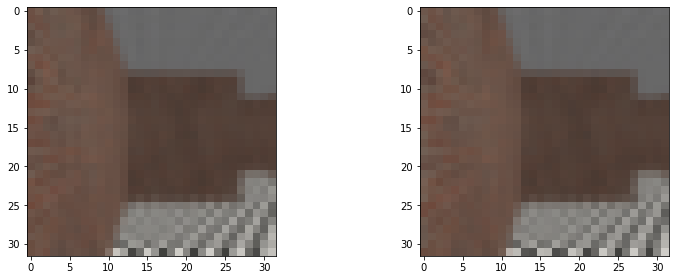

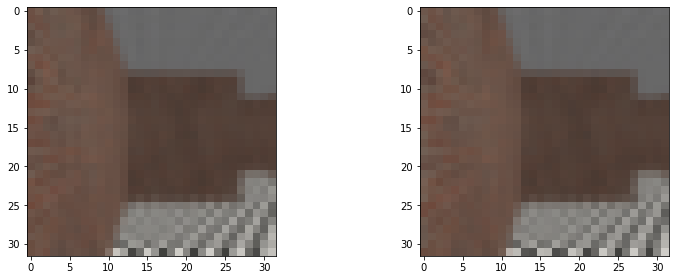

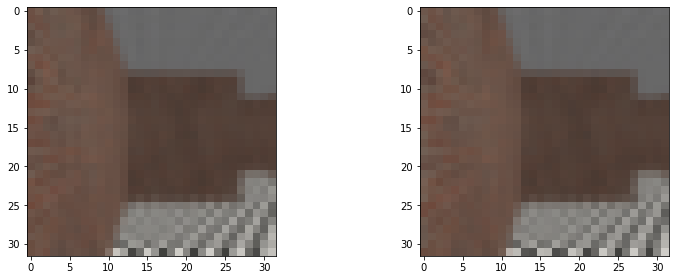

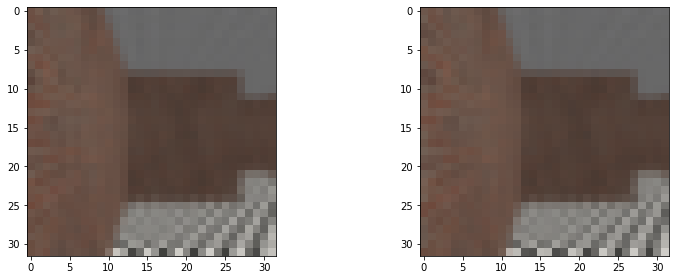

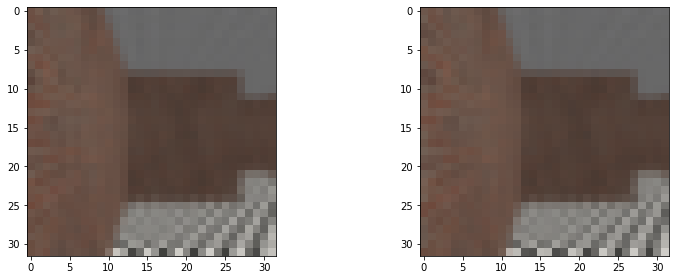

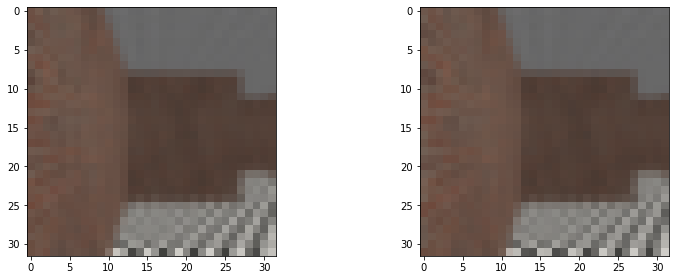

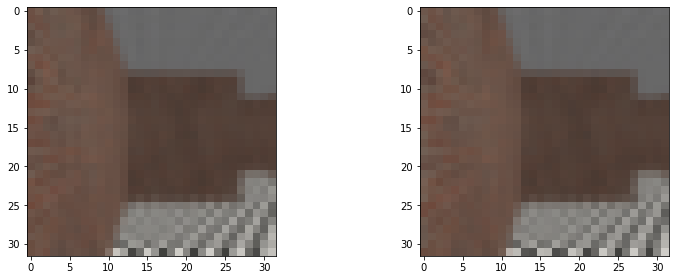

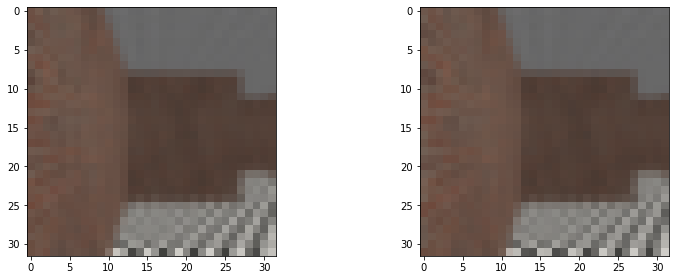

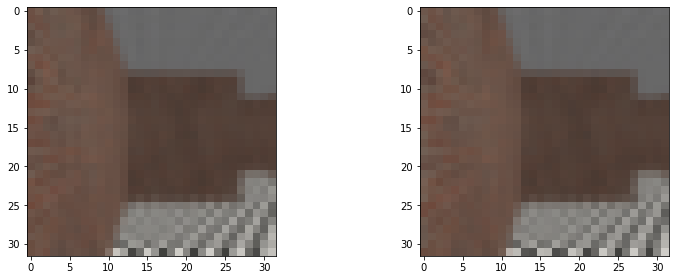

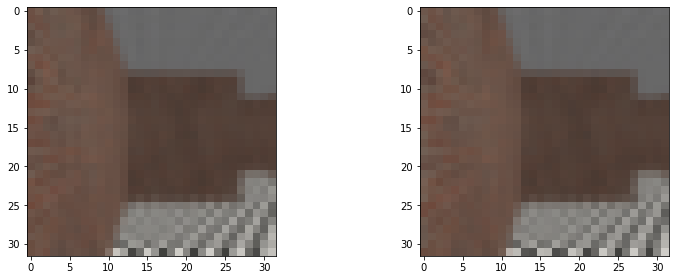

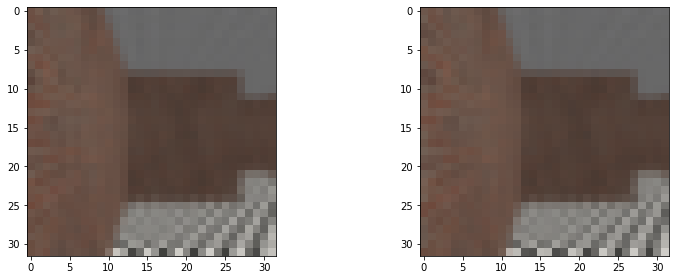

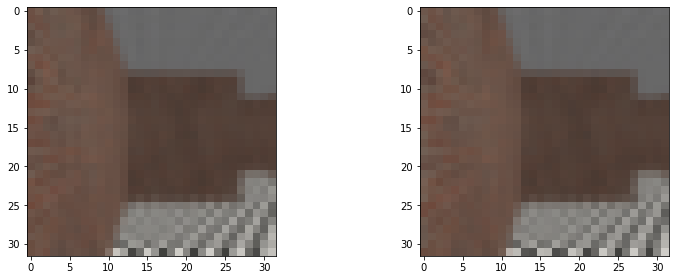

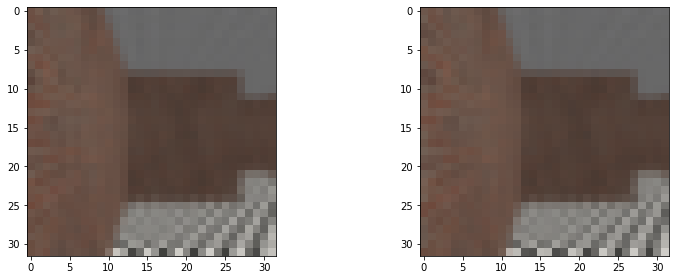

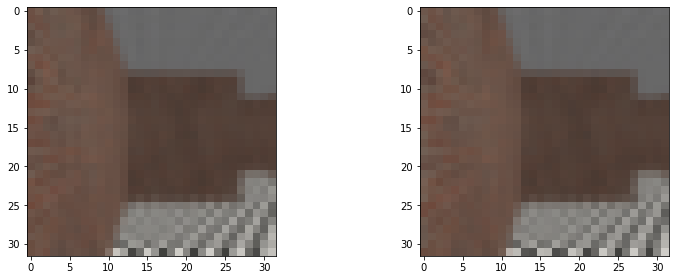

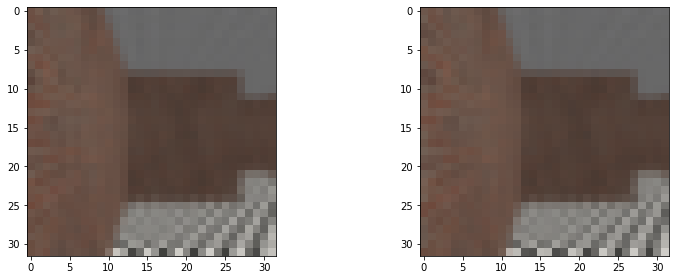

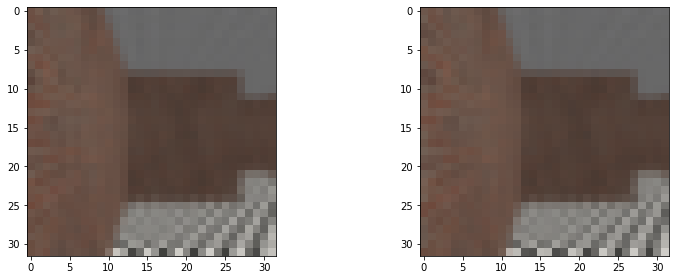

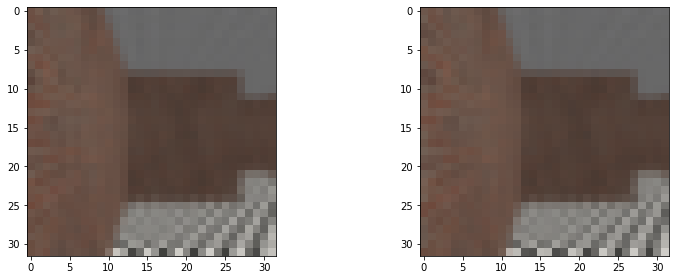

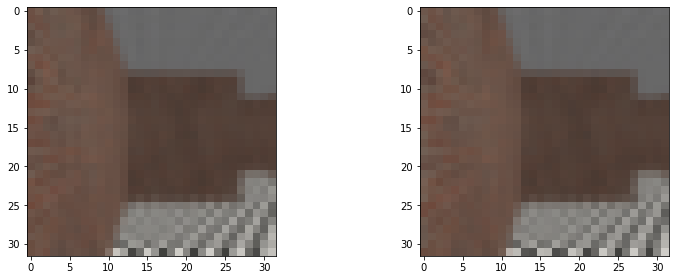

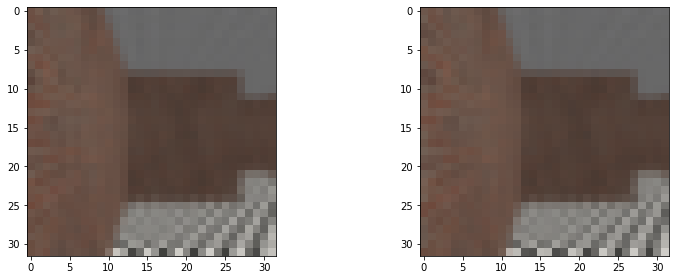

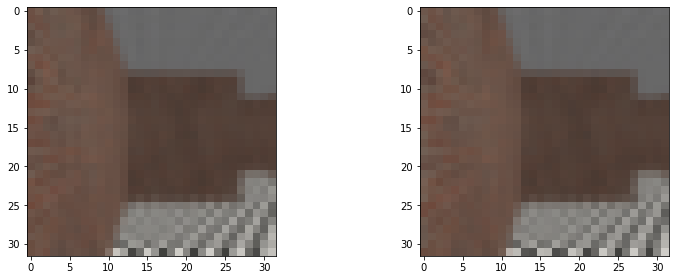

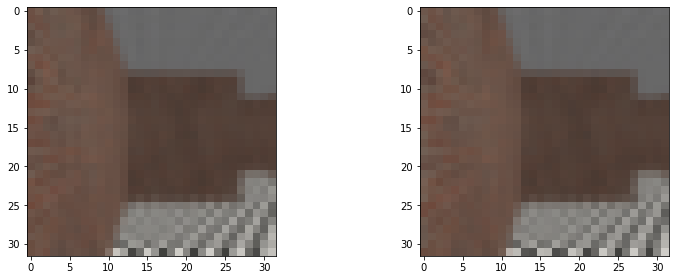

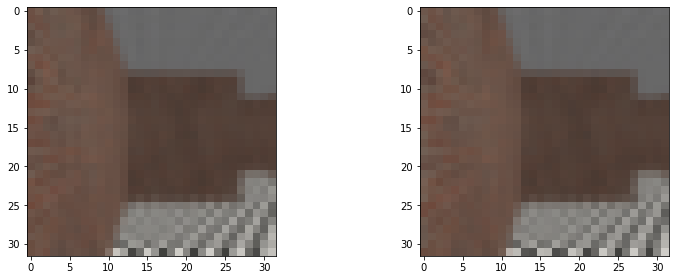

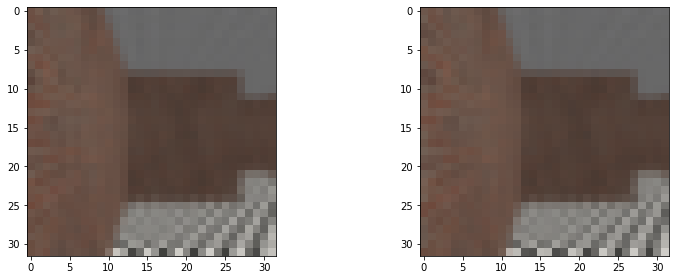

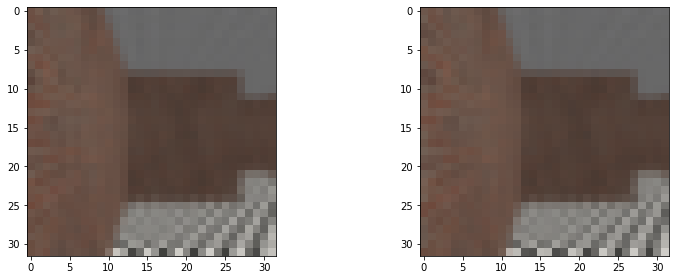

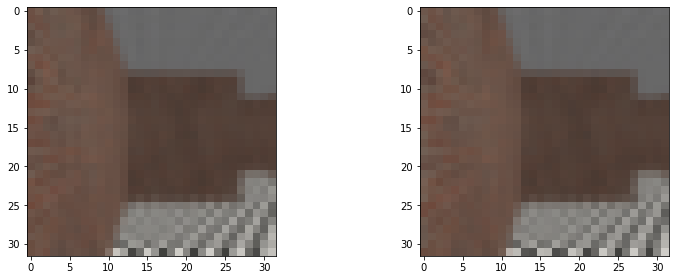

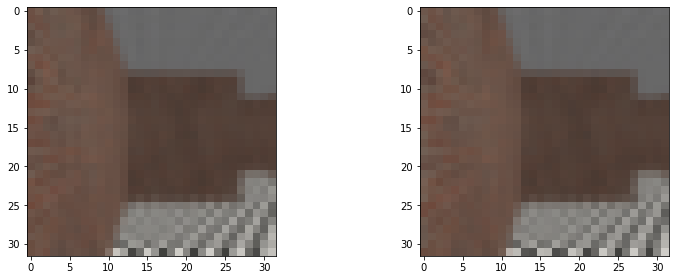

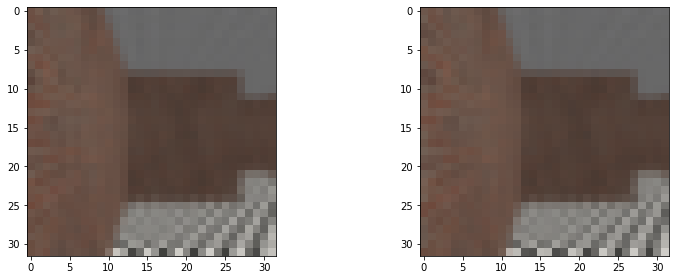

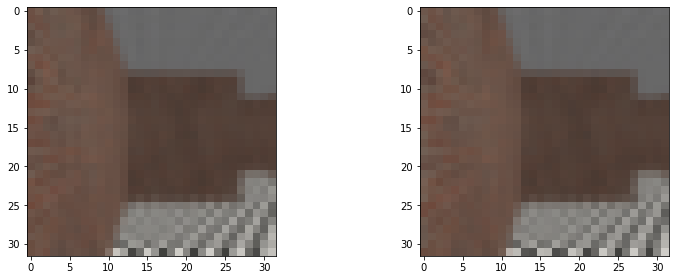

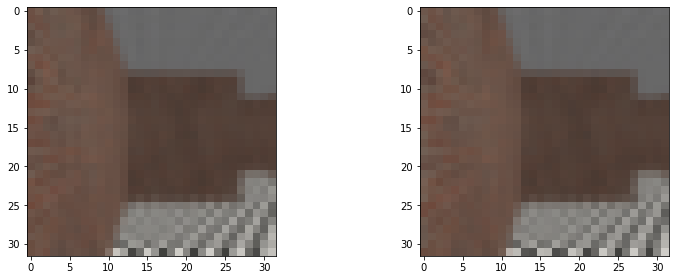

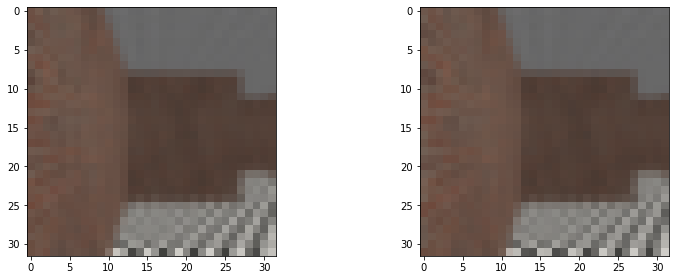

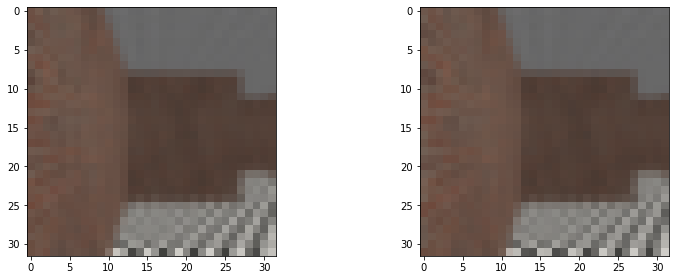

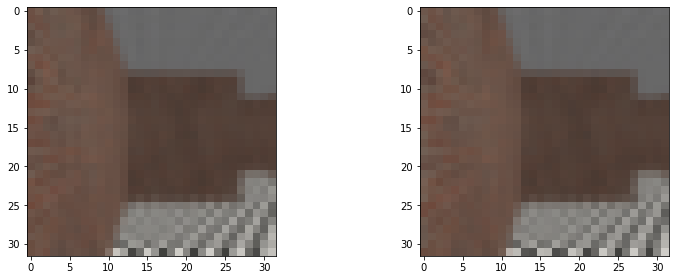

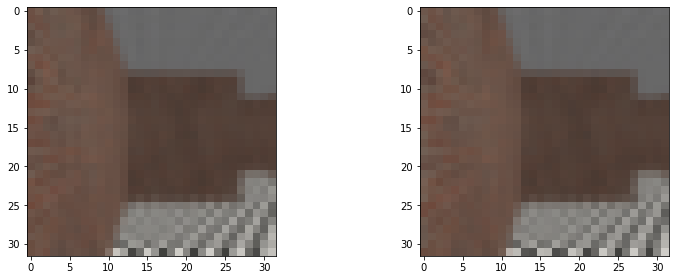

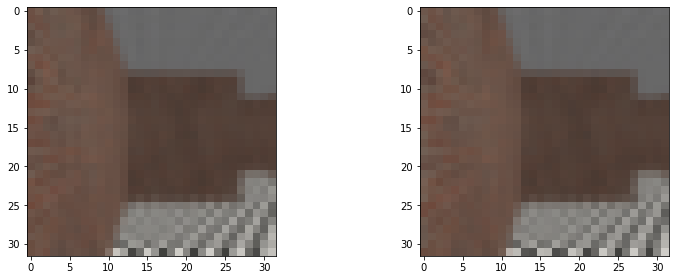

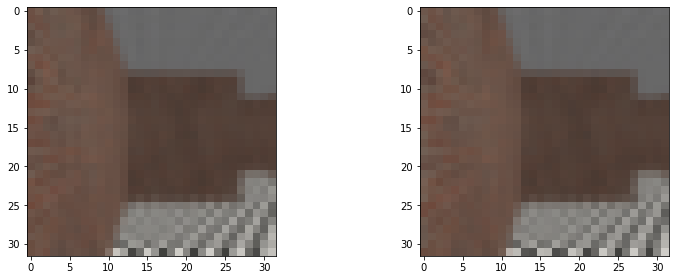

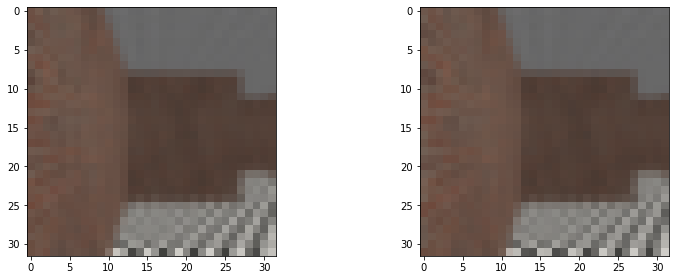

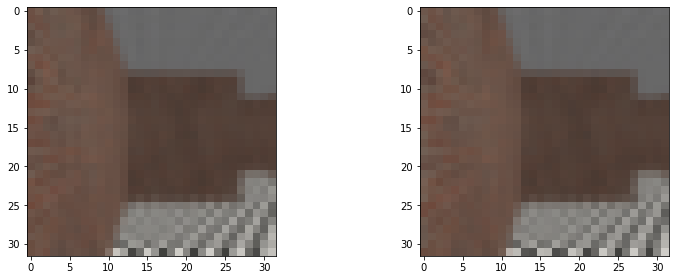

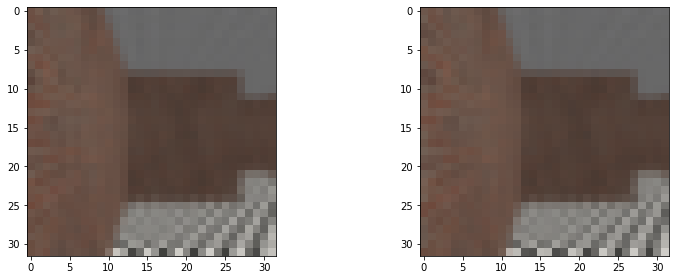

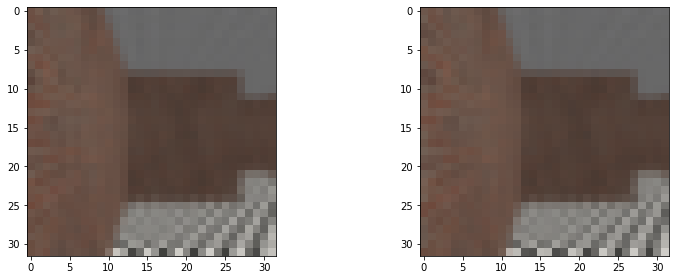

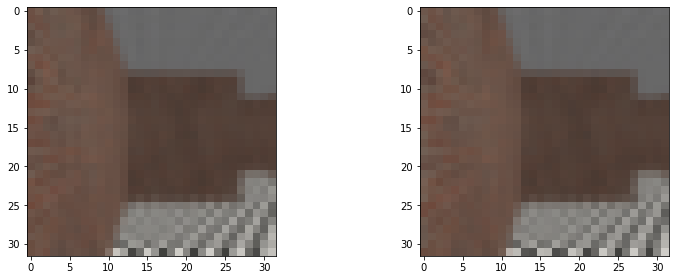

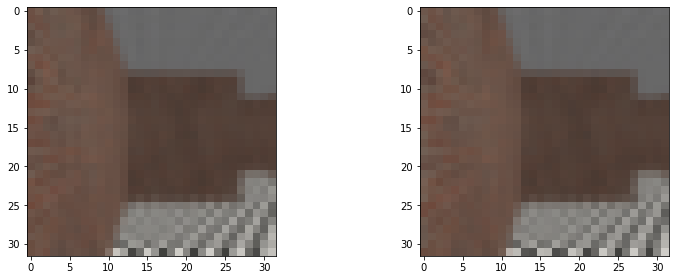

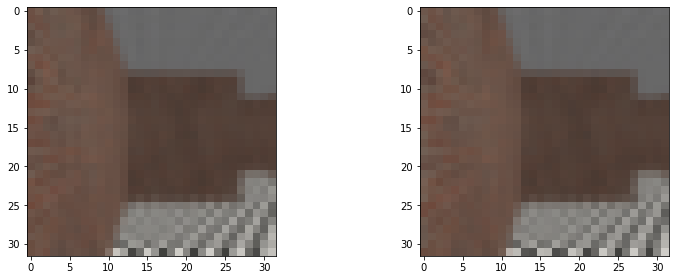

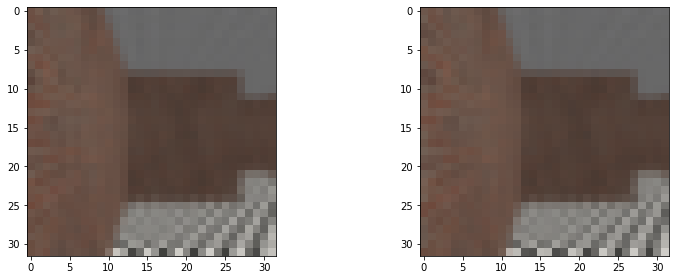

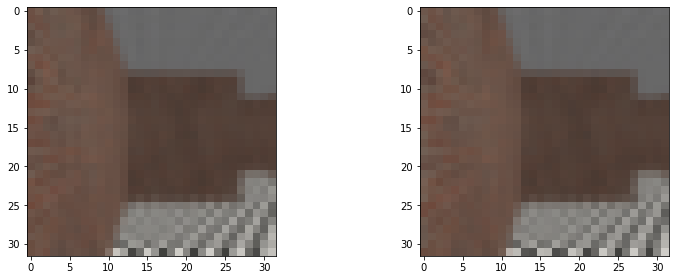

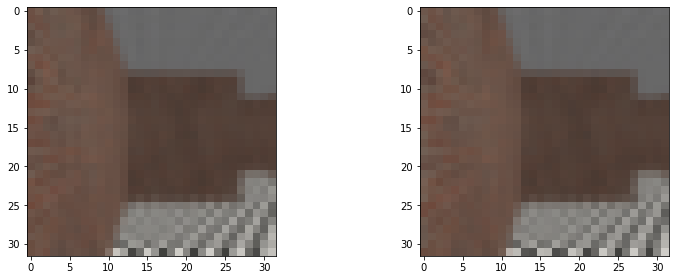

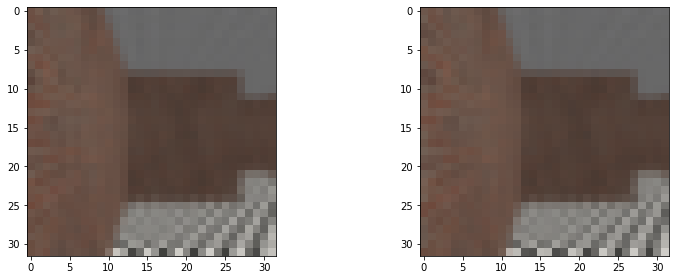

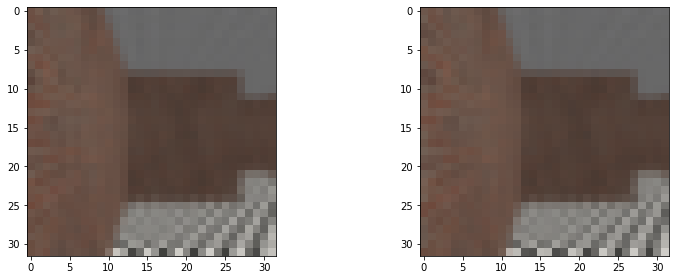

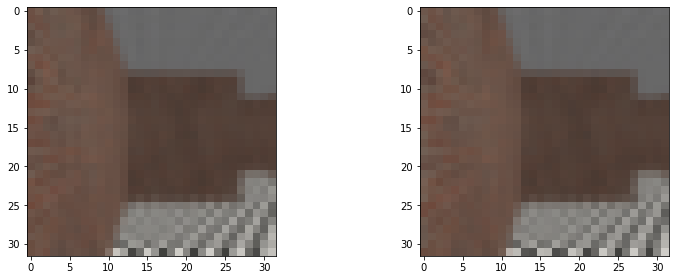

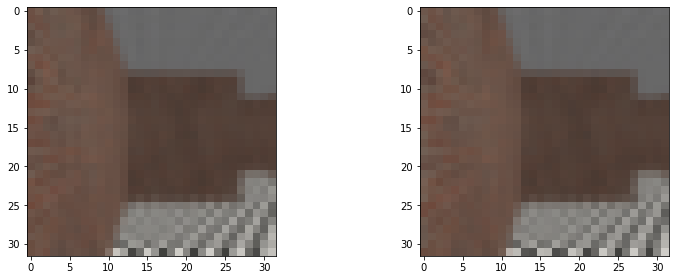

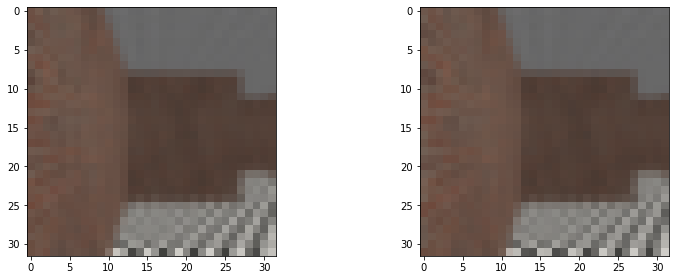

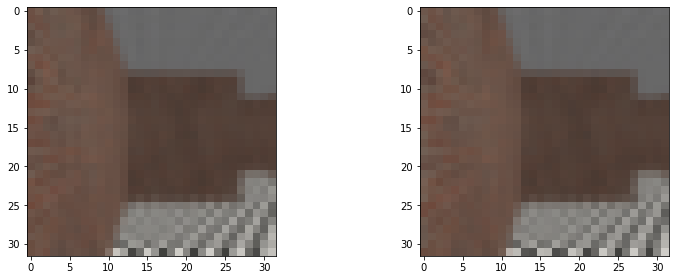

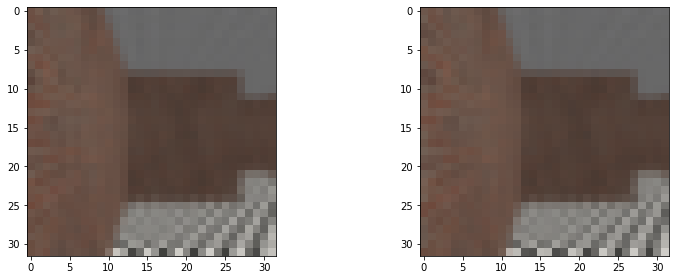

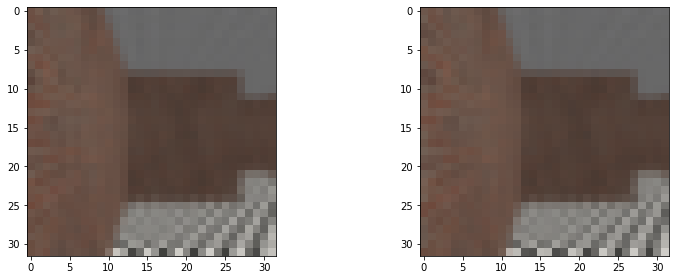

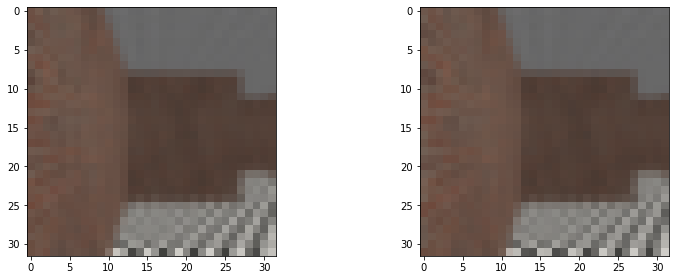

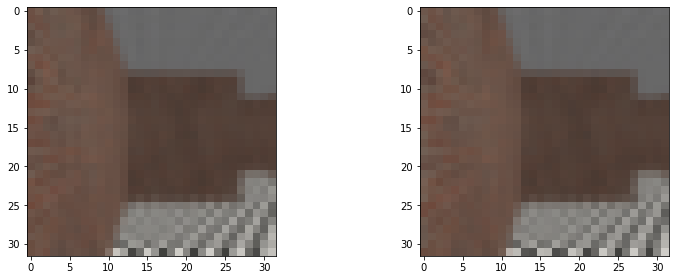

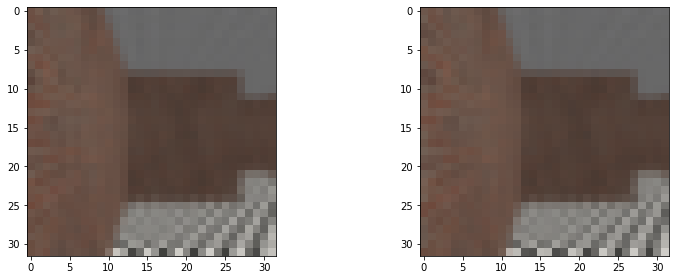

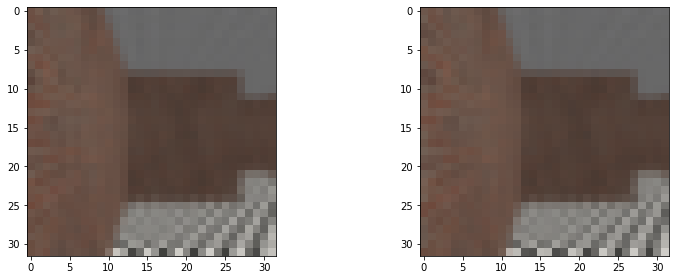

In [10]:
plot.plot_dataset_imgs(dataset)

### Initialize the model

In [5]:
DualInput_model = nets.DualInput(output_neurons=counter)
summary(DualInput_model, [(3, 32, 32), (3, 32, 32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 6, 28, 28]             456
         MaxPool2d-6            [-1, 6, 14, 14]               0
            Conv2d-7           [-1, 16, 10, 10]           2,416
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          96,120
           Linear-10                   [-1, 84]          10,164
           Linear-11                  [-1, 256]          21,760
Total params: 133,788
Trainable params: 133,788
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 36.00
Forward

### Tensorboard integrations

In [6]:
%load_ext tensorboard
%tensorboard --logdir=runs

### Train model

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    DualInput_model.parameters(), lr=0.001
)  # RMSProp, Adam, SDG (momentum=0.9)

episodes = 10
DualInput_model, train_loss, test_loss, train_acc, test_acc = train.train_DualInput(
    dataset_loader_train_data,
    dataset_loader_test_data,
    DualInput_model,
    criterion,
    optimizer,
    episodes,
)

Progress:   0%|          | 0/10 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 4.126, Train Acc: 4.839 %,  Test Loss: 4.085, Test Acc: 3.172 %,
Finished Training


### Plot loss and accuracy curves for training and test set

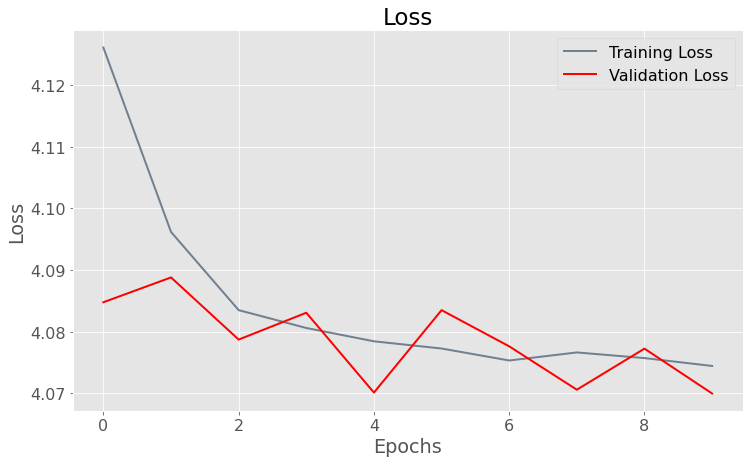

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [9]:
plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)